Marker "Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False" @ 17070.75s
Marker "Stopping Cognitive Load Tasks" @ 17110.76s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False" @ 17124.00s
Marker "Stopping Cognitive Load Tasks" @ 17164.01s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True" @ 17184.49s
Marker "Stopping Cognitive Load Tasks" @ 17224.50s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False" @ 17311.47s
Marker "Stopping Cognitive Load Tasks" @ 17351.48s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False" @ 17363.84s
Marker "Stopping Cognitive Load Tasks" @ 17403.85s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True" @ 17421.51s
Marker "Stopping Cognitive Load Tasks" @ 17461.52s
Marker "Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False" @ 17519.22s
Marker "Stopping Cognitive Load Tasks" @ 17559.23s
Marker "Star

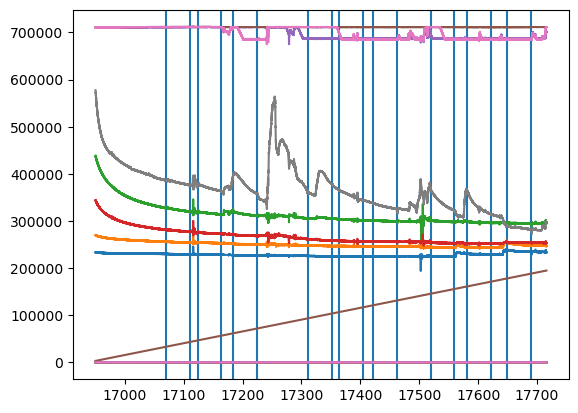

In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np

data, header = pyxdf.load_xdf('data/test2.xdf')

for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

In [2]:
import pyxdf

import mne
from mne.datasets import misc

fname = (
    misc.data_path() / 'xdf' /
    'sub-P001_ses-S004_task-Default_run-001_eeg_a2.xdf')
streams, header = pyxdf.load_xdf(fname)
data = streams[0]["time_series"].T
assert data.shape[0] == 5  # four raw EEG plus one stim channel
data[:4:2] -= data[1:4:2]  # subtract (rereference) to get two bipolar EEG
data = data[::2]  # subselect
data[:2] *= (1e-6 / 50 / 2)  # uV -> V and preamp gain
sfreq = float(streams[0]["info"]["nominal_srate"][0])
info = mne.create_info(3, sfreq, ["eeg", "eeg", "stim"])
raw = mne.io.RawArray(data, info)
#raw.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

Creating RawArray with float64 data, n_channels=3, n_times=2320128
    Range : 0 ... 2320127 =      0.000 ...   232.013 secs
Ready.


In [3]:

import pyxdf

import mne

fname = 'data/test2.xdf'
streams, header = pyxdf.load_xdf(fname)

# general structure
print(streams[0].keys())

# markers
# first treatment start
print(streams[0]['time_series'][0])
print(streams[0]['time_stamps'][0])
# first treatment stop
print(streams[0]['time_series'][1])
print(streams[0]['time_stamps'][1])


dict_keys(['info', 'footer', 'time_series', 'time_stamps'])
['Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False']
17070.75018659265
['Stopping Cognitive Load Tasks']
17110.756591294514


In [4]:
streams[0]["time_stamps"].shape[0]

18

Creating RawArray with float64 data, n_channels=17, n_times=191635
    Range : 0 ... 191634 =      0.000 ...   766.536 secs
Ready.
Using matplotlib as 2D backend.


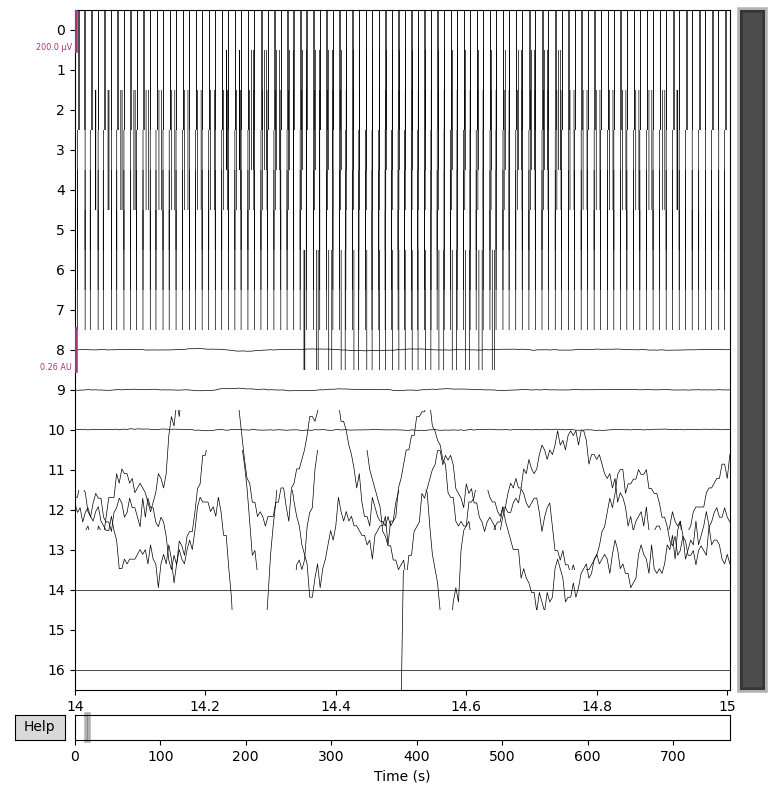

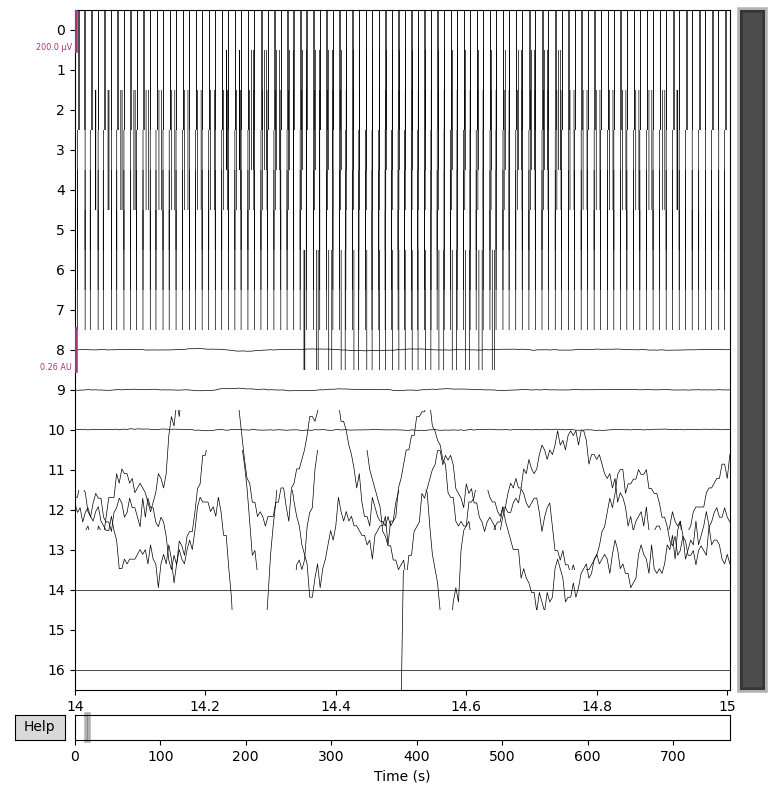

In [5]:
# data
data = streams[1]["time_series"].T
stamps = streams[1]["time_stamps"]
sfreq = float(streams[1]["info"]["nominal_srate"][0])
info = mne.create_info(17, sfreq, ["eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "misc", "misc", "misc", "misc", "misc", "misc", "misc", "misc", "misc"])
raw = mne.io.RawArray(data, info)
raw.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 67 samples (0.268 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1017010/2752344241.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


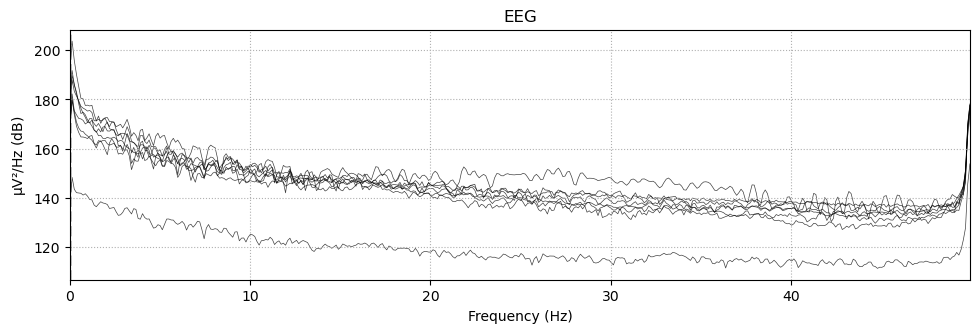

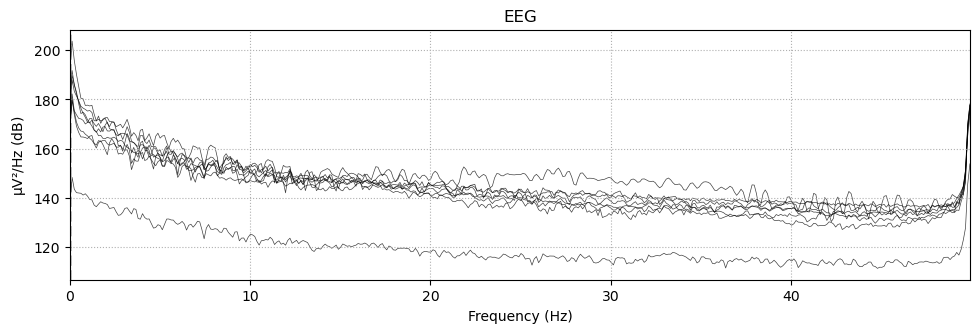

In [6]:
# low pass filtering below 50 Hz
raw.filter(None, 50., h_trans_bandwidth='auto', filter_length='auto',
           phase='zero')
raw.plot_psd(fmax=50)


In [7]:
import glob

# load baseline recordings
baseline_list = []
path = 'data/**/*S001*.xdf'
for file in glob.glob(path, recursive=True):
    baseline_list.append(file)

# load experiment recordings
experiment_list = []
path = 'data/**/*S002*.xdf'
for file in glob.glob(path, recursive=True):
    experiment_list.append(file)


In [8]:
trails = { 
          'ball': list(),
          'ball+number': list(),
          'ball+number+wheel': list(),
         }

for i in range(0, streams[0]["time_stamps"].shape[0], 2):
    start = streams[0]["time_stamps"][i]
    event = streams[0]["time_series"][i][0]
    stop = streams[0]["time_stamps"][i+1]
    print(start, stop, event)

    trial = []
    for j, stamp in enumerate(streams[1]["time_stamps"]):
        if start <= stamp and stamp <= stop: 
            trial.append(streams[1]["time_series"][j])
    
        match event:
            case 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
                key = 'ball'
            case 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
                key = 'ball+number'
            case 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
                key = 'ball+number+wheel'
            case _:
                raise("key not found!")

    trial = np.array(trial)
    
    trails[key].append(trial)

trails


17070.75018659265 17110.756591294514 Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False
17124.003900162024 17164.009538863895 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False
17184.48920511366 17224.49540621553 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True
17311.47396790218 17351.47998210405 Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False
17363.84491147372 17403.85085337559 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False
17421.513786732263 17461.52021163413 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True
17519.222655192596 17559.228892094467 Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False
17581.52451213978 17621.530868941645 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False
17649.35774297339 17689.36419057526 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True


{'ball': [array([[2.2969306e+05, 2.5529573e+05, 3.2652806e+05, ..., 7.3333336e+01,
          3.3204000e+04, 1.0000000e+00],
         [2.2990755e+05, 2.5555233e+05, 3.2679512e+05, ..., 7.3333336e+01,
          3.3205000e+04, 1.0000000e+00],
         [2.3021439e+05, 2.5601242e+05, 3.2742544e+05, ..., 7.3333336e+01,
          3.3206000e+04, 1.0000000e+00],
         ...,
         [2.2925900e+05, 2.5416591e+05, 3.1970703e+05, ..., 7.3333336e+01,
          4.3216000e+04, 1.0000000e+00],
         [2.2950978e+05, 2.5455616e+05, 3.2026950e+05, ..., 7.3333336e+01,
          4.3217000e+04, 1.0000000e+00],
         [2.2940920e+05, 2.5447220e+05, 3.2023559e+05, ..., 7.3333336e+01,
          4.3218000e+04, 1.0000000e+00]], dtype=float32),
  array([[2.2560564e+05, 2.4816839e+05, 3.0476712e+05, ..., 7.3333336e+01,
          9.3466000e+04, 1.0000000e+00],
         [2.2555844e+05, 2.4802311e+05, 3.0449766e+05, ..., 7.3333336e+01,
          9.3467000e+04, 1.0000000e+00],
         [2.2566403e+05, 2.481986

Creating RawArray with float64 data, n_channels=8, n_times=10015
    Range : 0 ... 10014 =      0.000 ...    40.056 secs
Ready.
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


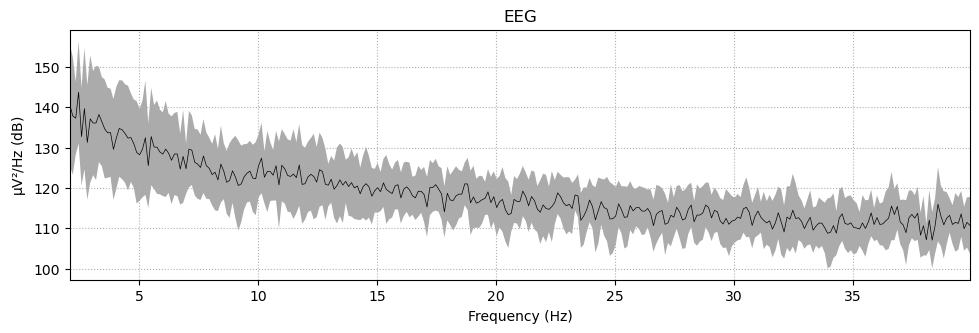

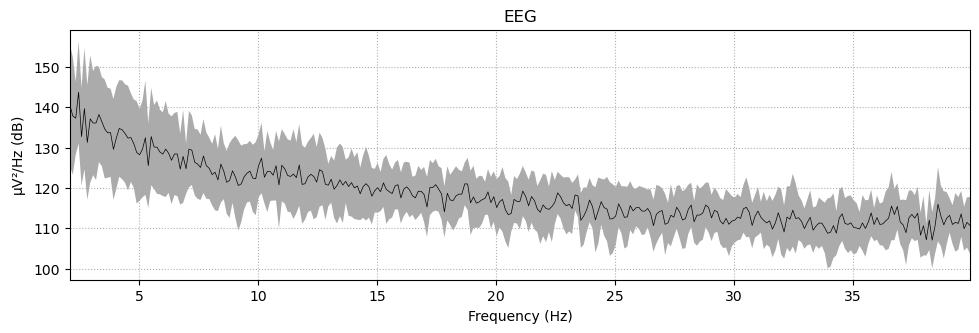

In [9]:
info = mne.create_info(8, sfreq, ["eeg"] * 8)
data = trails['ball'][0].T[:8]
raw = mne.io.RawArray(data, info)
raw.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)